In [1]:
# Libraries

# Data wrangling
#--------------------------------------------

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import missingno as msno 

import xlrd  #Excel files

# Text matching
#--------------------------------------------
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Data visualization
#--------------------------------------------

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# 1. Data ingestion and preprocesing.
## 1.1. Purchase behavior dataset.

The client provide us the dataset _QVI_purchase_behavior.csv_ with information related to customers, their family status and their segmentation.

The main features of the dataset are:
- LYLTY_CARD_NBR: Customer card number.
- LIFESTAGE: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school. 
- LIFESTAGE: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school. 


In [2]:
# Ingesting data from CSV files (QVI_purchase_behavior)

behavior=pd.read_csv('QVI_purchase_behaviour.csv', sep=',',
                     #nrows=1000,
                    )
behavior.head(3)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget


In [3]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


##### Missing values.

In [4]:
# Any missing values?
behavior.isnull().values.any()

False

In [5]:
# Total number of missing values
behavior.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

##### Duplicates.

In [6]:
# Duplicated rows
behavior.duplicated().sum()

0

In [7]:
print('There are ',behavior.LYLTY_CARD_NBR.unique().shape[0],' diferent customers.')

There are  72637  diferent customers.


There are no missing values and no duplicated rows on customers behavior dataset.

### 1.1.1. New feature FAMILY_UNIT.
For easier analysis we cancreate a new feature based on customer family status, SINGLES/COUPLES, FAMILIES or RETIREES.

In [8]:
behavior.LIFESTAGE.unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [9]:
# Re ordering category
LFS_CAT = CategoricalDtype(categories=['YOUNG SINGLES/COUPLES',
                                       'MIDAGE SINGLES/COUPLES',
                                       'OLDER SINGLES/COUPLES',
                                       'NEW FAMILIES',
                                       'YOUNG FAMILIES',
                                       'OLDER FAMILIES',
                                       'RETIREES'], ordered=True)
behavior.LIFESTAGE=behavior.LIFESTAGE.astype(LFS_CAT)


In [10]:
# Re ordering premium category
FAM_PREM = CategoricalDtype(categories=['Budget','Mainstream','Premium'], ordered=True)
behavior.PREMIUM_CUSTOMER=behavior.PREMIUM_CUSTOMER.astype(FAM_PREM)


In [11]:
# New feature - Family unit - SINGLES/COUPLES / FAMILIES / RETIREES
behavior['FAMILY_UNIT']=behavior.LIFESTAGE.str.split(' ',expand=True)[1].str.strip(' ').fillna('RETIREES')


# Re ordering new category
FAM_CAT = CategoricalDtype(categories=['SINGLES/COUPLES',
                                       'FAMILIES',
                                       'RETIREES'], ordered=True)
behavior.FAMILY_UNIT=behavior.FAMILY_UNIT.astype(FAM_CAT)


### 1.1.2. Understanding customer behavior data.

In [12]:
behavior[['FAMILY_UNIT']].value_counts().sort_index()

FAMILY_UNIT    
SINGLES/COUPLES    36325
FAMILIES           21507
RETIREES           14805
dtype: int64

In [13]:
behavior[['LIFESTAGE']].value_counts(normalize=False).sort_index()

LIFESTAGE             
YOUNG SINGLES/COUPLES     14441
MIDAGE SINGLES/COUPLES     7275
OLDER SINGLES/COUPLES     14609
NEW FAMILIES               2549
YOUNG FAMILIES             9178
OLDER FAMILIES             9780
RETIREES                  14805
dtype: int64

In [14]:
behavior[['PREMIUM_CUSTOMER']].value_counts(normalize=True).sort_index()

PREMIUM_CUSTOMER
Budget              0.336881
Mainstream          0.402619
Premium             0.260501
dtype: float64

Almost 50% of our customers are into Singles/Couples familiy category followed by 30% of families and 20% of retirees.

The larger groups by lifestage category are young singles, older singles and retiree standing 20% each one.

Premium customers are only 26% of total.

Let's see how are crosses distributions on our customers:

In [15]:
# PREMIUM_CUSTOMER vs FAMILY_UNIT

a=round(pd.crosstab(index=behavior['FAMILY_UNIT'],
            columns=behavior['PREMIUM_CUSTOMER'],
            margins=False).apply(lambda r: r/len(behavior) *100,
                                axis=1)
      ,1)
a

PREMIUM_CUSTOMER,Budget,Mainstream,Premium
FAMILY_UNIT,,,
SINGLES/COUPLES,14.1,22.5,13.4
FAMILIES,13.5,8.8,7.3
RETIREES,6.1,8.9,5.3


In [16]:
#sns.jointplot(data=behavior,
#             x='PREMIUM_CUSTOMER',
#             y='FAMILY_UNIT',
#             kind='hist',
#             cmap='Blues',
#             color='lightsteelblue',)

In [17]:
# More detailed PREMIUM_CUSTOMER vs LIFESTAGE

round(pd.crosstab(index=behavior['LIFESTAGE'],
            columns=behavior['PREMIUM_CUSTOMER'],
            margins=True).apply(lambda r: r/len(behavior) *100,
                                axis=1)
      ,1)

PREMIUM_CUSTOMER,Budget,Mainstream,Premium,All
LIFESTAGE,,,,
YOUNG SINGLES/COUPLES,5.2,11.1,3.5,19.9
MIDAGE SINGLES/COUPLES,2.1,4.6,3.3,10.0
OLDER SINGLES/COUPLES,6.8,6.8,6.5,20.1
NEW FAMILIES,1.5,1.2,0.8,3.5
YOUNG FAMILIES,5.5,3.8,3.3,12.6
OLDER FAMILIES,6.4,3.9,3.1,13.5
RETIREES,6.1,8.9,5.3,20.4
All,33.7,40.3,26.1,100.0


In [18]:
#sns.jointplot(data=behavior,
#             x='PREMIUM_CUSTOMER',
#             y='LIFESTAGE',
#             kind='hist',
#             cmap='Blues',
#             color='lightsteelblue',)

## 1.2. Transactions Dataset
Transactions dataset has been provided in xlsx format. On that file we will have information about all the purchases made on client's stores, dates, customers number, product charts and sales amount.

Main features en that file are:
- DATE: Provided in excel format. So we need to transform to datetime
- STORE_NBR: Store number
- LYLTY_CARD_NBR:
- TXN_ID: 
- PROD_NBR: Product code, unique for each product.
- PROD_NAME: Product name. 114 diferent products where sold.
- PROD_QTY: Number of products purchased.
- TOT_SALES: 

Next task is check the features looking for inconsistencies or outliers, clean the data and get some extra information and once data are ready join behaviors and transactions tables to take a look deeper on our clients performance. 

In [19]:
# Ingesting data from transactions (QVI_transaction_data.xlsx)
transaction=pd.read_excel('QVI_transaction_data.xlsx',sheet_name='in',engine='xlrd')

In [20]:
transaction.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9


In [21]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


### Missing values.

In [22]:
transaction.isna().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Aparently there are no missing values (Nan) on transactions dataset.

### Duplicated values.

In [23]:
# Is any duplicated row?
transaction.duplicated().any()

True

In [24]:
# Number of Duplicated rows
transaction.duplicated().sum()

1

In [25]:
transaction[transaction.duplicated()]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
124845,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


In [26]:
transaction[transaction.TXN_ID==108462]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
124843,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0
124844,43374,107,107024,108462,18,Cheetos Chs & Bacon Balls 190g,2,6.6
124845,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


There is one transaction where I found a duplicated row, I will supose that for this transaction the costumer bought that product twice so there is no need for dropping this row.  

### Formating Date properly. 

DATE is provided on excel format so it is needed to read and transform on python datetime format in order to process our dataframe.



In [27]:
## XLRD methods to format excel dates into python 
#xlrd.xldate_as_tuple(transaction.DATE[0],0)
#xlrd.xldate_as_datetime(transaction.DATE[0],0)

### Opening days.
But firs let's check how many days our stores were open.

In [28]:
transaction.DATE.unique().shape

(364,)

There are 364 diferent dates so there is one missing day, closing day probably. Which day do our client close?


In [29]:
# Gap on days.
opening_days=transaction.groupby('DATE')['DATE'].unique()
opening_days.diff()[opening_days.diff()>1]

DATE
43460    [2]
Name: DATE, dtype: object

In [30]:
# Formating
xlrd.xldate_as_datetime(43459,0)

datetime.datetime(2018, 12, 25, 0, 0)

The only day of the year that our stores are closed is on christmas day.

For read dates properly I will use xlrd library as following.

In [31]:
# Datemode of the excel file (https://xlrd.readthedocs.io/en/latest/api.html#module-xlrd.book)
xlrd.open_workbook("QVI_transaction_data.xlsx").datemode

0

In [32]:
# Read excel date format to datetime
transaction.DATE=pd.to_datetime(transaction.DATE.apply(lambda x: xlrd.xldate_as_datetime(x,0)))
#pd.to_datetime(DATE, units='D',origin=01/01/1900)

In [33]:
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [34]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.2+ MB


In [35]:
# Total number of stores.
transaction.STORE_NBR.unique().shape  # 272 stores

(272,)

In [36]:
# Total of customers card numbers
transaction.LYLTY_CARD_NBR.unique().shape

(72637,)

### Product name vs Product number

In [37]:
# Total of products
transaction.PROD_NBR.unique().shape

(114,)

In [38]:
# Total of products by name
transaction.PROD_NAME.unique().shape

(114,)

In [39]:
# Checking there are no inconsistencies betweeen Name and code.
transaction.drop_duplicates(subset=['PROD_NBR','PROD_NAME'],keep='first').shape[0]

114

There are 114 diferent products in our stores. There are no inconsistecies between names and codes.

### Analyzing Product name.

In [40]:
pd.set_option('display.max_rows', 114) 
prod_name=transaction['PROD_NAME'].unique()
prod_name

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [41]:
pd.set_option('display.max_rows', 10) 

Product name has three chunks of information, brand name, product name and packet size. If we take a look on the product name list, it seems the there are three kind of products chips, nachos and salsa on our stores, so it is time to create a new feature PROD_TYPE.

In [42]:
# Product type related feature
transaction['PROD_TYPE']='Chips'
transaction.loc[transaction.PROD_NAME.str.contains('([Ss]alsa)'),'PROD_TYPE']='Salsa'
transaction.loc[transaction.PROD_NAME.str.contains('([Nn]achos?)'),'PROD_TYPE']='Nachos'

C:\Users\iukan\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [43]:
# Pct of salsa number of sales.
transaction['PROD_TYPE'].value_counts(normalize=True)*100

Chips     91.409023
Salsa      6.832153
Nachos     1.758824
Name: PROD_TYPE, dtype: float64

In [44]:
# Packet size
transaction['PROD_SIZE']=transaction.PROD_NAME.str.extract(r'(\d+[gG])')[0].str.slice(0,-1).astype('int')

### Brand Name.

It is possible to extract brand name from product name feature.

In [45]:
# Dataframe with product name
products=transaction[['PROD_NAME']].drop_duplicates().reset_index(drop=True)

In [46]:
# First word of each product unique vector
products['PROD_NAME'].str.split(' ',expand=True)[0].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos',
       'Cheetos', 'Snbts', 'Sunbites'], dtype=object)

Acording to that unique list of words I will be able to guess brand names so I write list with all brands.

In [47]:
brands=['Natural Chips Co.', 'CCs','Smiths','Kettle', 'Old El Paso','Grain Waves',
        'Doritos','Twisties','Woolworths','Thins','Burguer Rings','Cheezels','Infuzions',
        'Red Rock Dely','Pringles','Tyrrels','Cobs','French Fries','Tostitos','Cheetos','Sunbites']

NCC and WW are more likely to be confused with diferent brands so I will replace them with their actual brand name. 

In [48]:
products['FIRST_WORD']=products['PROD_NAME'].str.split(' ',expand=True)[0]
products['FIRST_WORD']=products['FIRST_WORD'].str.replace('NCC','Natural Chips Co.')
products['FIRST_WORD']=products['FIRST_WORD'].str.replace('WW','Woolworths')

In [49]:
products['BRAND']=products.FIRST_WORD.apply(lambda x:process.extractOne(x.split(' ')[0],
                                                           brands,
                                                           scorer=fuzz.WRatio)[0])

In [50]:
pd.set_option('display.max_rows', 114) 
products

,PROD_NAME,FIRST_WORD,BRAND
0,Natural Chip Compny SeaSalt175g,Natural,Natural Chips Co.
1,CCs Nacho Cheese 175g,CCs,CCs
2,Smiths Crinkle Cut Chips Chicken 170g,Smiths,Smiths
3,Smiths Chip Thinly S/Cream&Onion 175g,Smiths,Smiths
4,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Kettle,Kettle
5,Old El Paso Salsa Dip Tomato Mild 300g,Old,Old El Paso
6,Smiths Crinkle Chips Salt & Vinegar 330g,Smiths,Smiths
7,Grain Waves Sweet Chilli 210g,Grain,Grain Waves
8,Doritos Corn Chip Mexican Jalapeno 150g,Doritos,Doritos
9,Grain Waves Sour Cream&Chives 210G,Grain,Grain Waves


In [51]:
transaction=transaction.merge(products[['BRAND','PROD_NAME']],
                  how='left',
                  left_on='PROD_NAME',
                  right_on='PROD_NAME')

In [52]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264836 entries, 0 to 264835
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
 8   PROD_TYPE       264836 non-null  object        
 9   PROD_SIZE       264836 non-null  int32         
 10  BRAND           264836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(3)
memory usage: 23.2+ MB


### Describing numeric features and looking for outliers.
For a first approach I use Pandas _describe()_ function.

In [53]:
transaction.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PROD_SIZE
count,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000,264836.000000
mean,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200,182.427004
std,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226,64.327196
min,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000,150.000000
50%,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000,170.000000
75%,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000,175.000000
max,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000,380.000000


On PROD_QTY and TOT_SALES there are two strange values at maximun. lets check it.

In [54]:
# Outliers for TOT SALES
IQR=transaction.TOT_SALES.quantile(0.75)-transaction.TOT_SALES.quantile(0.25)
print('lower whisker: ',transaction.TOT_SALES.quantile(0.25)-IQR*1.5)
print('upper whisker: ', transaction.TOT_SALES.quantile(0.75)+IQR*1.5)

lower whisker:  -0.29999999999999805
upper whisker:  14.899999999999999


In [55]:
transaction[transaction.TOT_SALES>14.89].shape[0]

578

There are 578 transactions that can be defined as outliers, but I will focus on maximun value.

In [56]:
transaction[transaction.TOT_SALES>29]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TYPE,PROD_SIZE,BRAND
5179,2018-08-15,94,94148,93390,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths
55558,2019-05-14,190,190113,190914,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths
69496,2018-08-15,49,49303,45789,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,Chips,380,Doritos
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,Chips,380,Doritos
117850,2019-05-19,194,194308,194516,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths
150683,2019-05-20,118,118021,120799,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths
171815,2018-08-17,24,24095,20797,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths
184969,2019-05-20,44,44350,40394,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5,Chips,380,Smiths


In [57]:
transaction[transaction['LYLTY_CARD_NBR']==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TYPE,PROD_SIZE,BRAND
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,Chips,380,Doritos
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,Chips,380,Doritos


That client only did two sales for same amount of chips. For our analysis it will be convenient to drop those rows.

In [58]:
# Drop maximun sales ever.
transaction.drop(index=transaction[transaction.TOT_SALES>50].index,inplace=True)

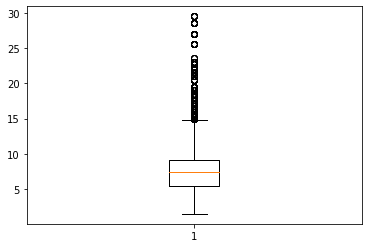

In [59]:
plt.boxplot(transaction['TOT_SALES']);

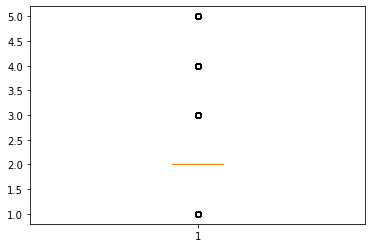

In [60]:
plt.boxplot(transaction['PROD_QTY']);

## 1.3. Merging datasets.

In [61]:
transaction=transaction.merge(behavior,
                              how='left',
                              on='LYLTY_CARD_NBR'
                             # left_on='LYLTY_CARD_NBR',
                             # right_on='LYLTY_CARD_NBR',
                                )


In [62]:
transaction=transaction.reindex(columns=['DATE','STORE_NBR','LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER', 'FAMILY_UNIT',         
                     'TXN_ID','PROD_NBR','PROD_NAME','PROD_TYPE','PROD_SIZE', 'BRAND','PROD_QTY', 'TOT_SALES']);

In [63]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264834 entries, 0 to 264833
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              264834 non-null  datetime64[ns]
 1   STORE_NBR         264834 non-null  int64         
 2   LYLTY_CARD_NBR    264834 non-null  int64         
 3   LIFESTAGE         264834 non-null  category      
 4   PREMIUM_CUSTOMER  264834 non-null  category      
 5   FAMILY_UNIT       264834 non-null  category      
 6   TXN_ID            264834 non-null  int64         
 7   PROD_NBR          264834 non-null  int64         
 8   PROD_NAME         264834 non-null  object        
 9   PROD_TYPE         264834 non-null  object        
 10  PROD_SIZE         264834 non-null  int32         
 11  BRAND             264834 non-null  object        
 12  PROD_QTY          264834 non-null  int64         
 13  TOT_SALES         264834 non-null  float64       
dtypes: c

# 2. Exploratory data analysis.
## 2.1. Analyzing sales.


In [64]:
# Total sales.
summary={'Total_Sales':round(transaction.TOT_SALES.sum(),1),
         'Total_transactions':transaction.TXN_ID.count(),
         'Transactions_per_day':round(transaction.TXN_ID.count()/364,1),
         'Sales_per_day':round(transaction.TOT_SALES.sum()/364,1),
         'Avg_sales_per_transaction':round(transaction.TOT_SALES.sum()/transaction.TXN_ID.count(),1),
         'Total_products':transaction.PROD_QTY.sum(),
         'Avg_product_prize':round(transaction.TOT_SALES.sum()/transaction.PROD_QTY.sum(),1)}

for x,y in summary.items():
    print(x,' :',y)


Total_Sales  : 1933115.0
Total_transactions  : 264834
Transactions_per_day  : 727.6
Sales_per_day  : 5310.8
Avg_sales_per_transaction  : 7.3
Total_products  : 504724
Avg_product_prize  : 3.8


In [65]:
# Total Sales per Store and day.
transaction.groupby(['DATE','STORE_NBR'])['TOT_SALES'].sum().describe()

count    78641.000000
mean        24.581516
std         16.945435
min          1.500000
25%         10.700000
50%         21.100000
75%         34.800000
max        140.200000
Name: TOT_SALES, dtype: float64

In [66]:
# Total Sales and number of transacions per day.
transaction.groupby('DATE')[['TOT_SALES','TXN_ID']].agg({'TOT_SALES':'sum',
                                                         'TXN_ID':'count'}).describe()

,TOT_SALES,TXN_ID
count,364.000000,364.000000
mean,5310.755495,727.565934
std,327.353701,35.255049
min,4036.500000,648.000000
25%,5165.975000,706.750000
50%,5327.100000,724.000000
75%,5468.525000,744.250000
max,6923.000000,939.000000


### 2.1.1. Sales across time.

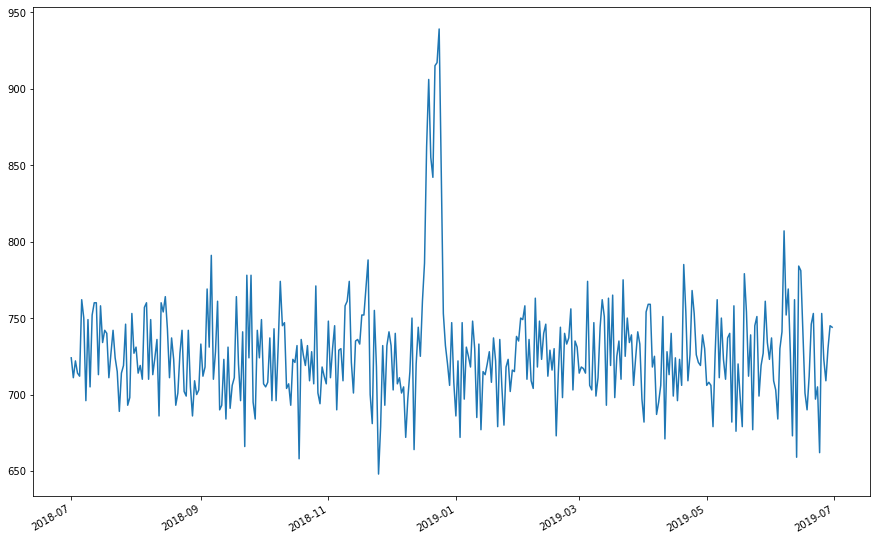

In [67]:
# Sales vs Time
transaction['DATE'].value_counts().plot(figsize=(15,10));

In [68]:
#transaction['YEAR']=transaction.DATE.dt.year
#transaction['MONTH']=transaction.DATE.dt.month
#transaction['DayOfMonth']=transaction.DATE.dt.day

In [69]:
# Reshaping dataframe for heatmap printing
sales_by_day=transaction.groupby('DATE')[['TOT_SALES']].sum().reset_index()
sales_by_day['YEAR']=sales_by_day.DATE.dt.year
sales_by_day['MONTH']=sales_by_day.DATE.dt.month
sales_by_day['DayOfMonth']=sales_by_day.DATE.dt.day
sales_by_day.set_index(['YEAR','MONTH'],inplace=True)
sales_by_day.drop(columns='DATE',inplace=True)

In [70]:
sales_by_day_HEATMAP=sales_by_day.pivot_table(index=['YEAR','MONTH'],
                                              columns='DayOfMonth',
                                              values='TOT_SALES').fillna(0)

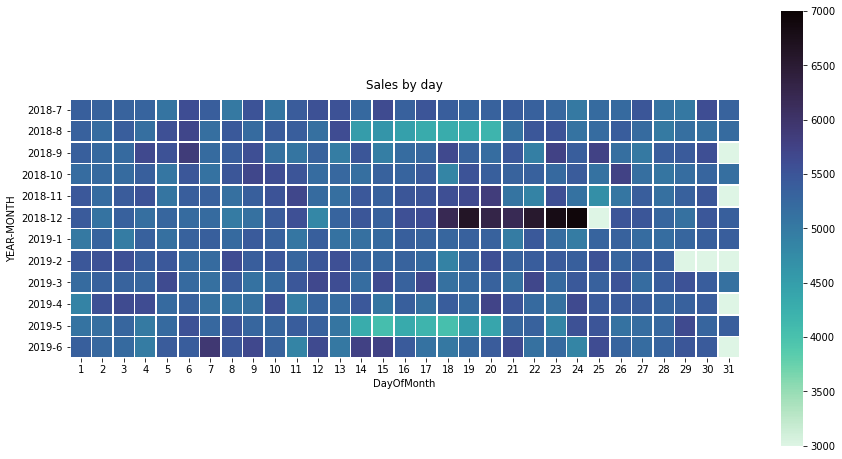

In [71]:
# Heatmap SALES BY DAY

# Plot
plt.figure(figsize=(15,8))
heatmap_01 =sns.heatmap(data=sales_by_day_HEATMAP,
                        cmap='mako_r',
                        square=True,
                        linewidth=0.5, linecolor='w',
                        vmin=3000,
                        vmax=7000,
                       # annot=True, fmt='f',
                       )

# Set title
heatmap_01.set_title('Sales by day',pad=10);


# Guardar imagen
# plt.savefig('genero_year',dpi=200)
plt.show()

In [72]:
transaction['Day_of_week']=transaction.DATE.dt.dayofweek
transaction.groupby('Day_of_week')[['TOT_SALES']].agg(lambda x: sum(x)/52)

,TOT_SALES
Day_of_week,
0,5275.306731
1,5204.692308
2,5343.776923
3,5241.647115
4,5375.409615
5,5300.242308
6,5434.213462


As we can check on graphs, sales are very constant all across the year except:
- From 17th december untill 24fh december sales were specially large. 
- There are two weeks 14-21 agust 2018 and 14-21 may 2019 with lower sales rate.

Wednesdays, fridays and specially sundays are the week days with higer demand but in general the sales are quite stable along the week.

### 2.1.2. Sales by product.

In [73]:
transaction.groupby('PROD_NAME')[['TOT_SALES']].sum().sort_values(by='TOT_SALES',ascending=False).head(5)

,TOT_SALES
PROD_NAME,
Dorito Corn Chp Supreme 380g,39052.0
Smiths Crnkle Chip Orgnl Big Bag 380g,36367.6
Smiths Crinkle Chips Salt & Vinegar 330g,34804.2
Kettle Mozzarella Basil & Pesto 175g,34457.4
Smiths Crinkle Original 330g,34302.6


In [74]:
transaction.groupby('PROD_NAME')[['TOT_SALES']].sum().sort_values(by='TOT_SALES',ascending=False).tail(5)

,TOT_SALES
PROD_NAME,
WW Crinkle Cut Chicken 175g,4702.2
Sunbites Whlegrn Crisps Frch/Onin 90g,4600.2
WW Crinkle Cut Original 175g,4532.2
Woolworths Mild Salsa 300g,4234.5
Woolworths Medium Salsa 300g,4050.0


In [75]:
SALES_BY_BRAND=transaction.groupby('BRAND')[['TOT_SALES']].sum().sort_values(by='TOT_SALES',ascending=False)
SALES_BY_TYPE=transaction.groupby('PROD_TYPE')[['TOT_SALES']].sum().sort_values(by='TOT_SALES',ascending=False)

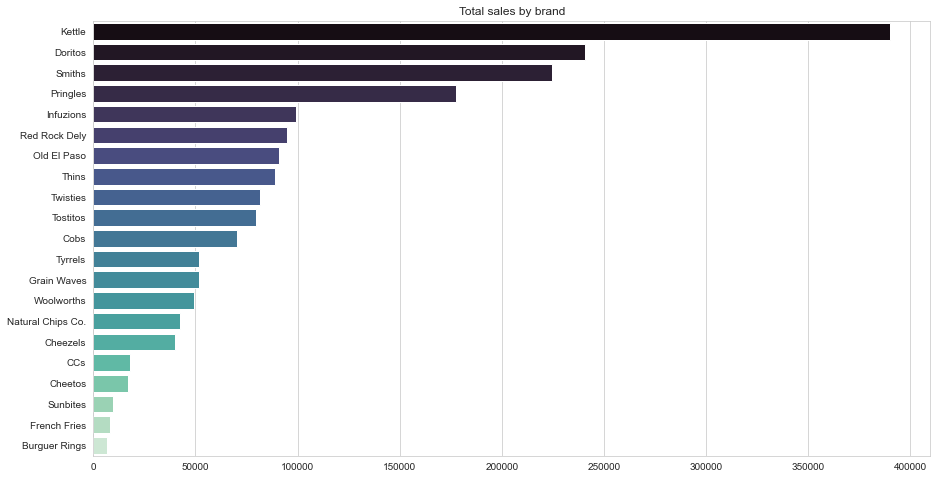

In [76]:
# Bar plot - Sales by brand
sns.set_style('whitegrid')
# 1. Fig y axes.
fig, ax=plt.subplots(figsize=(15, 8))

# 2. Plot
SxB=sns.barplot(data=SALES_BY_BRAND.reset_index(),
                  x='TOT_SALES',
                  y='BRAND',
                  ci=None,
                  palette='mako',)

# 3.Title 
SxB.set(title='Total sales by brand',
          ylabel=None,
          xlabel=None);

# Anotaciones
#for i in range(5):
#    SxB.annotate(text=int(SALES_BY_BRAND.reset_index().iloc[i,1]),
#                  xy=(SALES_BY_BRAND.reset_index().iloc[i,1]-30000,i+0.25),
#                  xycoords='data',
#                  color='w',
#                  weight='bold',
#                  fontstyle='oblique');




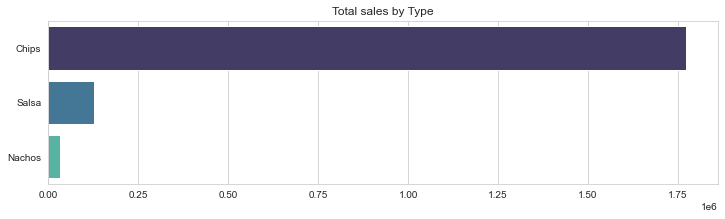

In [77]:
# Bar plot - Sales by type
# 1. Fig y axes.
fig, ax=plt.subplots(figsize=(12, 3))

# 2. Plot
SxB=sns.barplot(data=SALES_BY_TYPE.reset_index(),
                  x='TOT_SALES',
                  y='PROD_TYPE',
                  ci=None,
                  palette='mako',)

# 3.Title 
SxB.set(title='Total sales by Type',
          ylabel=None,
          xlabel=None);


Kettle is the most selled brand, followed by Doritos, Smith and pringles.

In [78]:
# Four most important brands sales percentage of total sales
SALES_BY_BRAND.head(4).sum()/SALES_BY_BRAND.sum()*100

TOT_SALES    53.444642
dtype: float64

### 2.1.3. Sales by customer.

Now I want to analize the distribution of our clients and their impact on sales.

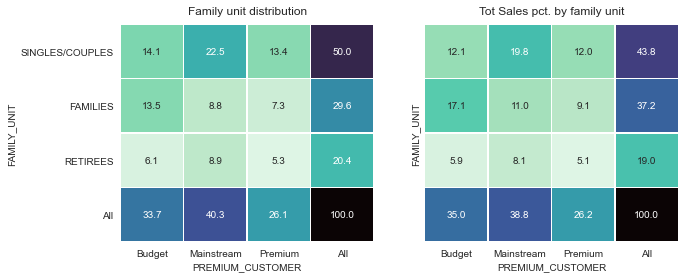

In [79]:
# Total sales by family unit
sales_by_family=round(transaction.pivot_table(values='TOT_SALES',
                                        index='FAMILY_UNIT',
                                        columns='PREMIUM_CUSTOMER',
                                        aggfunc='sum',
                                        margins=True).apply(lambda x:x/transaction.TOT_SALES.sum()*100),1)
# Family unit distribution
family_dist=round(pd.crosstab(index=behavior['FAMILY_UNIT'],
                            columns=behavior['PREMIUM_CUSTOMER'],
                              margins=True).apply(lambda r: r/len(behavior) *100,axis=1),1)                    

# 1. Fig and axes.
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),sharey=True)

#2. Plot. 
# Ax1 family distribution plot
ax1_plot=sns.heatmap(family_dist,
              annot=True, fmt='.1f',  
              cmap='mako_r', cbar=False,
              vmax=60,
              linewidth=0.5, linecolor='w',
              ax=ax1)

ax1.set_title('Family unit distribution',pad=10);

# Ax2 sales by family distribution plot
ax2_plot=sns.heatmap(sales_by_family,
                  annot=True, fmt='.1f',  
                  cmap='mako_r', cbar=False,
                  vmax=60,
                  linewidth=0.5, linecolor='w',
                 ax=ax2)

ax2.set_title('Tot Sales pct. by family unit',pad=10);


Families which are a 29.6 % of ouer clients, makes 37.2 percent of our sales. On the other side, singles/couples use to buy less. But let dig a bit more on our segments.

In [80]:
# Customer distribution
customer_dist=round(pd.crosstab(index=behavior['LIFESTAGE'],
                                columns=behavior['PREMIUM_CUSTOMER'],
                                margins=True).apply(lambda r: r/len(behavior) *100,axis=1),1)
# Sales by customer
sales_by_customer=round(transaction.pivot_table(values='TOT_SALES',
                                        index='LIFESTAGE',
                                        columns='PREMIUM_CUSTOMER',
                                        aggfunc='sum',
                                        margins=True).apply(lambda x:x/transaction.TOT_SALES.sum()*100),1)

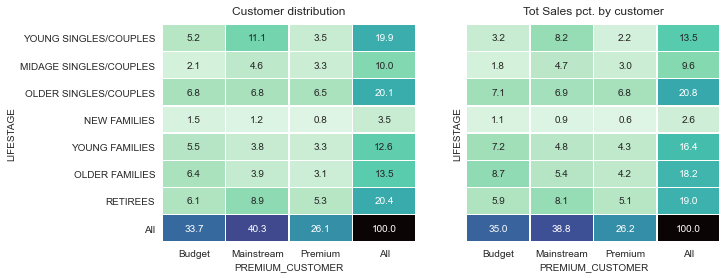

In [97]:

# 1. Fig and axes.
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),sharey=True)

#2. Plot.
customer=sns.heatmap(customer_dist,
                  annot=True, fmt='.1f',  
                  cmap='mako_r', cbar=False,
                  vmax=60,
                  linewidth=0.5, linecolor='w',
                  ax=ax1
                    )
ax1.set_title('Customer distribution',pad=10)

sales=sns.heatmap(sales_by_customer,
                  annot=True, fmt='.1f',  
                  cmap='mako_r', cbar=False,
                  vmax=60,
                  linewidth=0.5, linecolor='w',
                 ax=ax2
                 )
ax2.set_title('Tot Sales pct. by customer',pad=10);

plt.savefig('customers',dpi=200);


Actually youg singles/couples and new families use to buy less tha expected. And young and older families use to make larger shops.

Main segments are:
- Mainstreams young singles/couples (8.2% tot_sales)
- Budget older families (8.7% tot_sales)
- Mainstreams retirees (8.1% tot_sales)

In [82]:
# Average number of items 
a=transaction.groupby(['LIFESTAGE','PREMIUM_CUSTOMER','LYLTY_CARD_NBR'])[['PROD_QTY']].sum().groupby(
    ['LIFESTAGE','PREMIUM_CUSTOMER'])[['PROD_QTY']].mean()


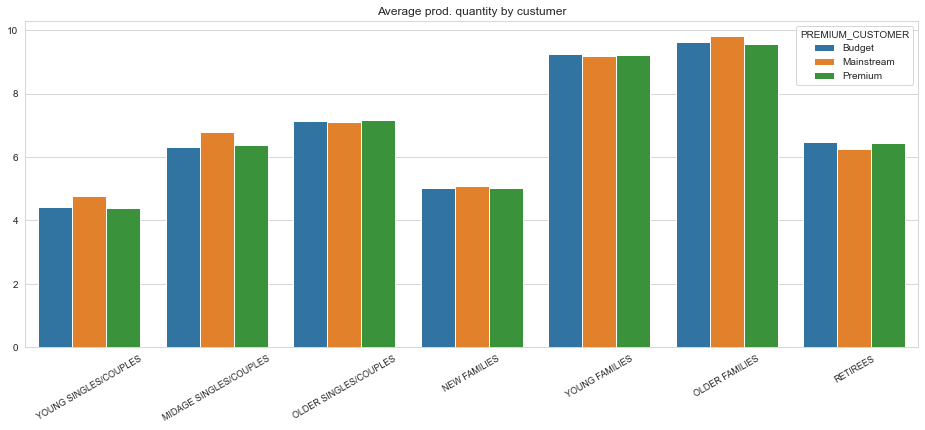

In [98]:

# Bar plot - Avg product by segment
# 1. Fig y axes.
fig, ax=plt.subplots(figsize=(16, 6))

# 2. Plot
SxS=sns.barplot(data=a.reset_index(),
                  y='PROD_QTY',
                  x='LIFESTAGE',
                  hue='PREMIUM_CUSTOMER',
               #   ci=None,
               )

# 3.Title 
SxS.set(title='Average prod. quantity by custumer',
          ylabel=None,
          xlabel=None)
ax.tick_params(axis='x',labelsize=9, rotation=30)


plt.savefig('units_segment',dpi=200);


As expected young and older families use to buy more units per customer.

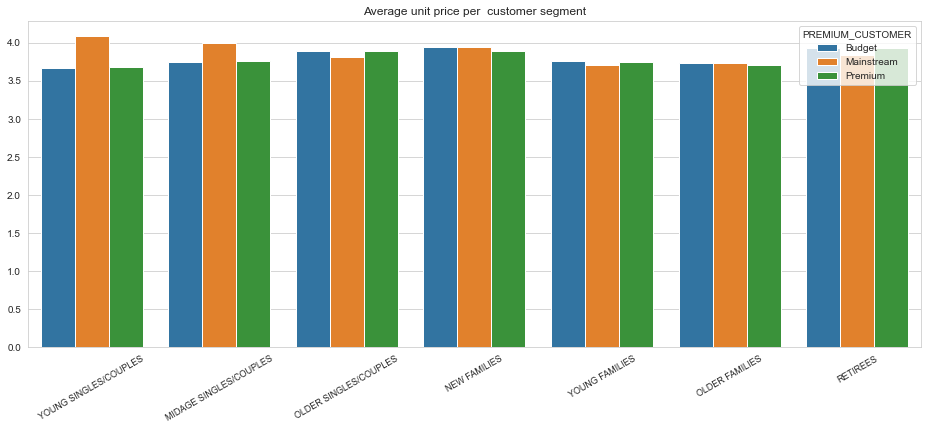

In [96]:

# Bar plot - Avg product by segment
# 1. Fig y axes.
fig, ax=plt.subplots(figsize=(16, 6))

b=transaction.groupby(['LIFESTAGE','PREMIUM_CUSTOMER','LYLTY_CARD_NBR'])[['TOT_SALES','PROD_QTY']].sum().groupby(
    ['LIFESTAGE','PREMIUM_CUSTOMER'])[['TOT_SALES','PROD_QTY']].mean()
b['Unit_Price']=b.TOT_SALES/b.PROD_QTY
# 2. Plot
SxS=sns.barplot(data=b.reset_index(),
                  y='Unit_Price',
                  x='LIFESTAGE',
                  hue='PREMIUM_CUSTOMER',
               #   ci=None,
               )

# 3.Title 
SxS.set(title='Average unit price per  customer segment',
          ylabel=None,
          xlabel=None)
ax.tick_params(axis='x',labelsize=9, rotation=30)

plt.savefig('avg_price_segment',dpi=200);
